Number of unique values in 'ActivityDate': 31
Number of unique values in 'Id': 7
Number of unique values in 'TotalSteps': 190
Number of unique values in 'TotalDistance': 165
Number of unique values in 'TrackerDistance': 165
Number of unique values in 'VeryActiveDistance': 86
Number of unique values in 'ModeratelyActiveDistance': 80
Number of unique values in 'LightActiveDistance': 169
Number of unique values in 'VeryActiveMinutes': 53
Number of unique values in 'FairlyActiveMinutes': 46
Number of unique values in 'LightlyActiveMinutes': 147
Number of unique values in 'SedentaryMinutes': 172
Number of unique values in 'Calories': 187
Number of unique values in 'TotalSleepRecords': 3
Number of unique values in 'TotalMinutesAsleep': 49
Number of unique values in 'TotalTimeInBed': 47
                 Id    TotalSteps  TotalDistance  TrackerDistance  \
count  2.160000e+02    216.000000     216.000000       216.000000   
mean   1.799900e+09   6507.472222       4.410139         4.410139   
st

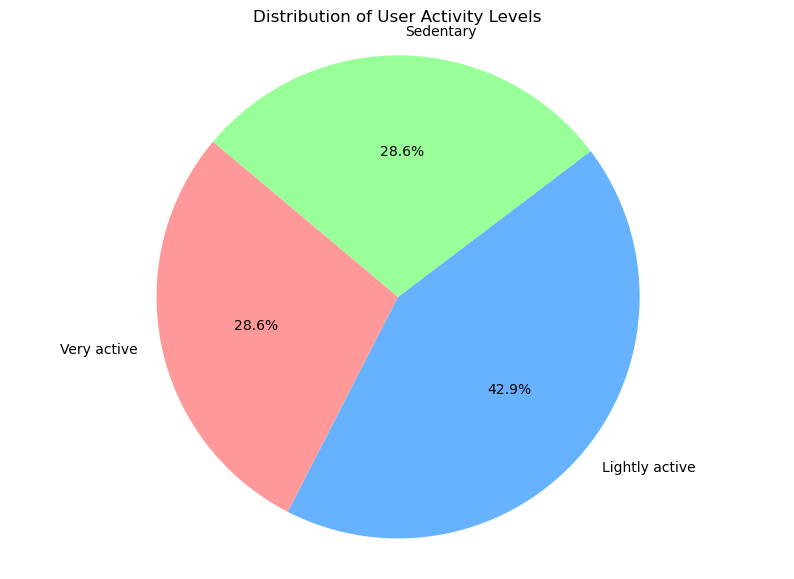

DayOfWeek
Friday       5779.142857
Monday       6687.214286
Saturday     7506.714286
Sunday       6600.607143
Thursday     6285.000000
Tuesday      6767.171429
Wednesday    6028.857143
Name: TotalSteps, dtype: float64


In [167]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
from Class import DataAnalyzer
from scipy import stats
import calendar
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Define the file path
file_path = r'C:\Users\ljfit\Desktop\Random Coding\Fitbit Project\sql_tables\fourth_stage.csv'

# Read the CSV file into a Pandas DataFrame
df = pd.read_csv(file_path)

# print(df.head())
# print(df.shape)
# print(df.info())
# print(df.dtypes)

# # Create a list of the column names
# column_names = list(df.columns)
# # Print the column names
# print(column_names)

# # Check for any missing values
# print(df.isnull().sum())

# Loop through each column and print the number of unique values
for column in df.columns:
    unique_values = df[column].nunique()
    print(f"Number of unique values in '{column}': {unique_values}")

# Describe the DataFrame
print(df.describe())

print(df.iloc[0])

# # Frequency Counts for ID
# print(df['Id'].value_counts())

# Drop any duplicate rows
# print(df.duplicated().sum())
df = df.drop_duplicates()

# # Save the cleaned DataFrame to a CSV file
# df.to_csv('fourth_stage_cleaned.csv', index=False)

# Convert 'ActivityDate' column to datetime type
df['ActivityDate'] = pd.to_datetime(df['ActivityDate'], format='%d/%m/%Y')

# Feature Engineering: Total active minutes
df['TotalActiveMinutes'] = df['VeryActiveMinutes'] + df['FairlyActiveMinutes'] + df['LightlyActiveMinutes']
total_active_minutes = df['TotalActiveMinutes'].sum()

# Feature Engineering: Split ActivityDate into year, month, day, day of week, weekend columns
df['Day'] = df['ActivityDate'].dt.day
df['DayOfWeek'] = df['ActivityDate'].dt.dayofweek
df['Weekend'] = np.where(df['DayOfWeek'] > 4, 1, 0) # Create weekend column (0 = Mon-Fri, 1 = Sat-Sun)

# Create an instance of the DataAnalyzer class
data_analyzer = DataAnalyzer(df)

## Setting each parameter individually can be done with the data_analyzer object as follows;
# # Example 1: Plot a single column
# data_analyzer.trend_and_subplot_by_id(
#     x_column="Day",
#     y_column="TotalSteps",
#     title_prefix="Total Steps Trend",
#     x_label="Date",
#     y_label="Total Steps",
#     plot_type="line"
# )
# # Example 2: Plot multiple columns (pass them as a list)
# data_analyzer.trend_and_subplot_by_id(
#     x_column="Day",
#     y_column=['VeryActiveMinutes','FairlyActiveMinutes','LightlyActiveMinutes'],
#     title_prefix="Steps and Distance Trend",
#     x_label="Date",
#     y_label="Values",
#     plot_type="line"
# )

# Calculate the correlation between total steps and calories burnt
correlation_steps_calories = df['TotalSteps'].corr(df['Calories'])

# Calculate the correlation between very active minutes and calories burnt
correlation_active_minutes_calories = df['VeryActiveMinutes'].corr(df['Calories'])

print('Correlation between total steps and calories burnt: ', correlation_steps_calories)
print('Correlation between very active minutes and calories burnt: ', correlation_active_minutes_calories)

# Descriptive Statistics of sedentary minutes
print(df['SedentaryMinutes'].describe())

# Divide the data into segments based on sedentary behavior.
# Discern sedentary categories
def sedentary_segment(minutes):
    if minutes < 4*60:  # Less than 4 hours
        return "Low sedentary"
    elif 4*60 <= minutes <= 8*60:  # 4-8 hours
        return "Moderate sedentary"
    else:  # More than 8 hours
        return "High sedentary"


# Apply the function to the sedentaryminutes column
df['Sedentary_Segment'] = df['SedentaryMinutes'].apply(sedentary_segment)
average_caloric_burn_per_segment = df.groupby('Sedentary_Segment')['Calories'].mean().rename('Average Caloric Burn').reset_index()
print(average_caloric_burn_per_segment)

# Group average steps, calories, and sleep by ID
daily_avg_ID = df.groupby('Id').agg({
    'TotalSteps': 'mean',
    'Calories': 'mean',
    'TotalMinutesAsleep': 'mean',
    'TotalActiveMinutes': 'mean'
}).reset_index()

# Rename columns for clarity
daily_avg_ID.columns = ['id', 'mean_daily_steps', 'mean_daily_calories', 'mean_daily_sleep', 'mean_daily_active_minutes']

# Customer Segmentation Analysis
def classify_by_steps(average_steps):
    if average_steps < 5000:
        return "Sedentary"
    elif 5000 <= average_steps < 7500:
        return "Lightly active"
    elif 7500 <= average_steps < 10000:
        return "Fairly active"
    else:
        return "Very active"

# Apply the function to the 'mean_daily_steps' column to create a new 'Activity_Category' column
daily_avg_ID['Activity_Category'] = daily_avg_ID['mean_daily_steps'].apply(classify_by_steps)
# Apply the function to the 'mean_daily_steps' column to create a new 'Sedentary_Category' column
daily_avg_ID['Sedentary_Category'] = daily_avg_ID['mean_daily_sleep'].apply(sedentary_segment)
print(daily_avg_ID)

# Group by 'Activity_Category' and count each group
user_type_percent = daily_avg_ID.groupby('Activity_Category').size().reset_index(name='total')
# Calculate the total number of users
user_type_percent['totals'] = user_type_percent['total'].sum()
# Calculate the percentage for each user type
user_type_percent['Total_Percent'] = user_type_percent['total'] / user_type_percent['totals']
# Convert the percentage to a readable format
user_type_percent['percentage%'] = user_type_percent['Total_Percent'].apply(lambda x: f"{x*100:.2f}%")
# Reorder the levels of the user type
ordered_categories = ["Very active", "Fairly active", "Lightly active", "Sedentary"]
user_type_percent['Activity_Category'] = pd.Categorical(user_type_percent['Activity_Category'], categories=ordered_categories, ordered=True)
user_type_percent = user_type_percent.sort_values('Activity_Category')
# Print DataFrame
print(user_type_percent)

# Print the pie chart
labels = user_type_percent['Activity_Category']
sizes = user_type_percent['Total_Percent']
plt.figure(figsize=(10, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['#ff9999','#66b2ff','#99ff99','#ffcc99'])
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribution of User Activity Levels')
plt.show()

# Convert the DatetimeIndex to day names
df['DayOfWeek'] = df['DayOfWeek'].apply(lambda x: calendar.day_name[x])

# Group by 'DayOfWeek' and calculate the mean by Id
steps_by_day = df.groupby('DayOfWeek')['TotalSteps'].mean()

print(steps_by_day)

# Initialize empty DataFrame to hold aggregated results
agg_df = pd.DataFrame()

# Group by 'Id'
grouped = df.groupby('Id')

Id: 1503960366
Id: 1624580081
Id: 1644430081
Id: 1844505072
Id: 1927972279
Id: 2022484408
Id: 2026352035
F statistic:  19.1433871744961 p-value:  5.04193182076913e-11


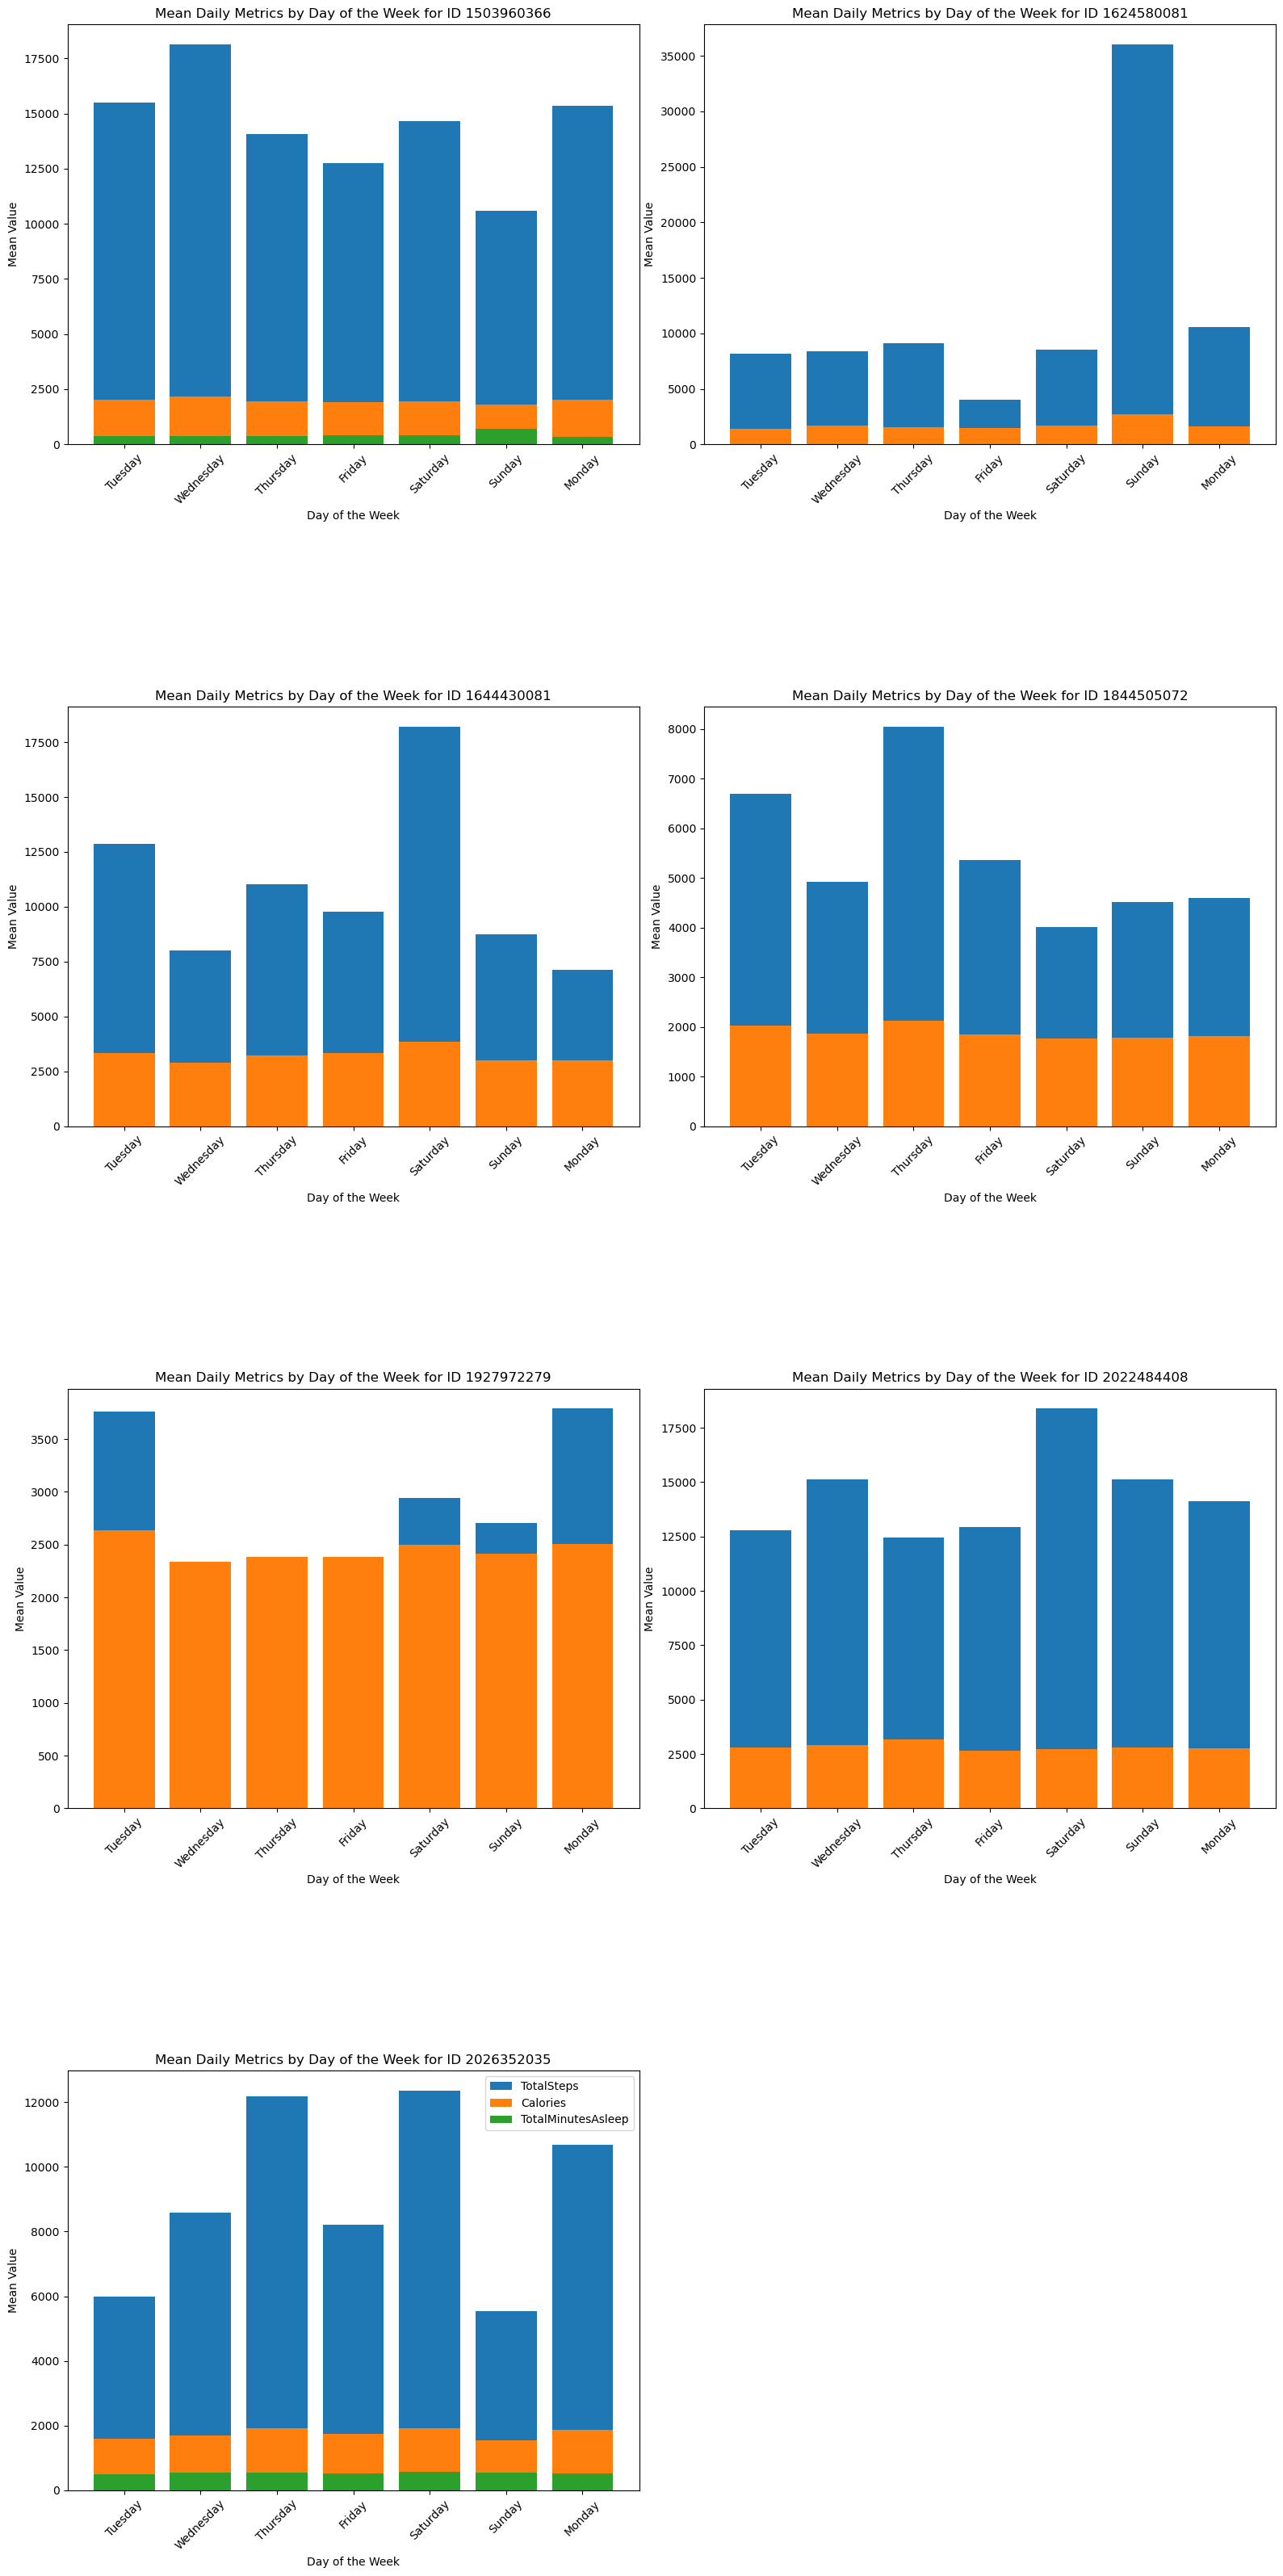

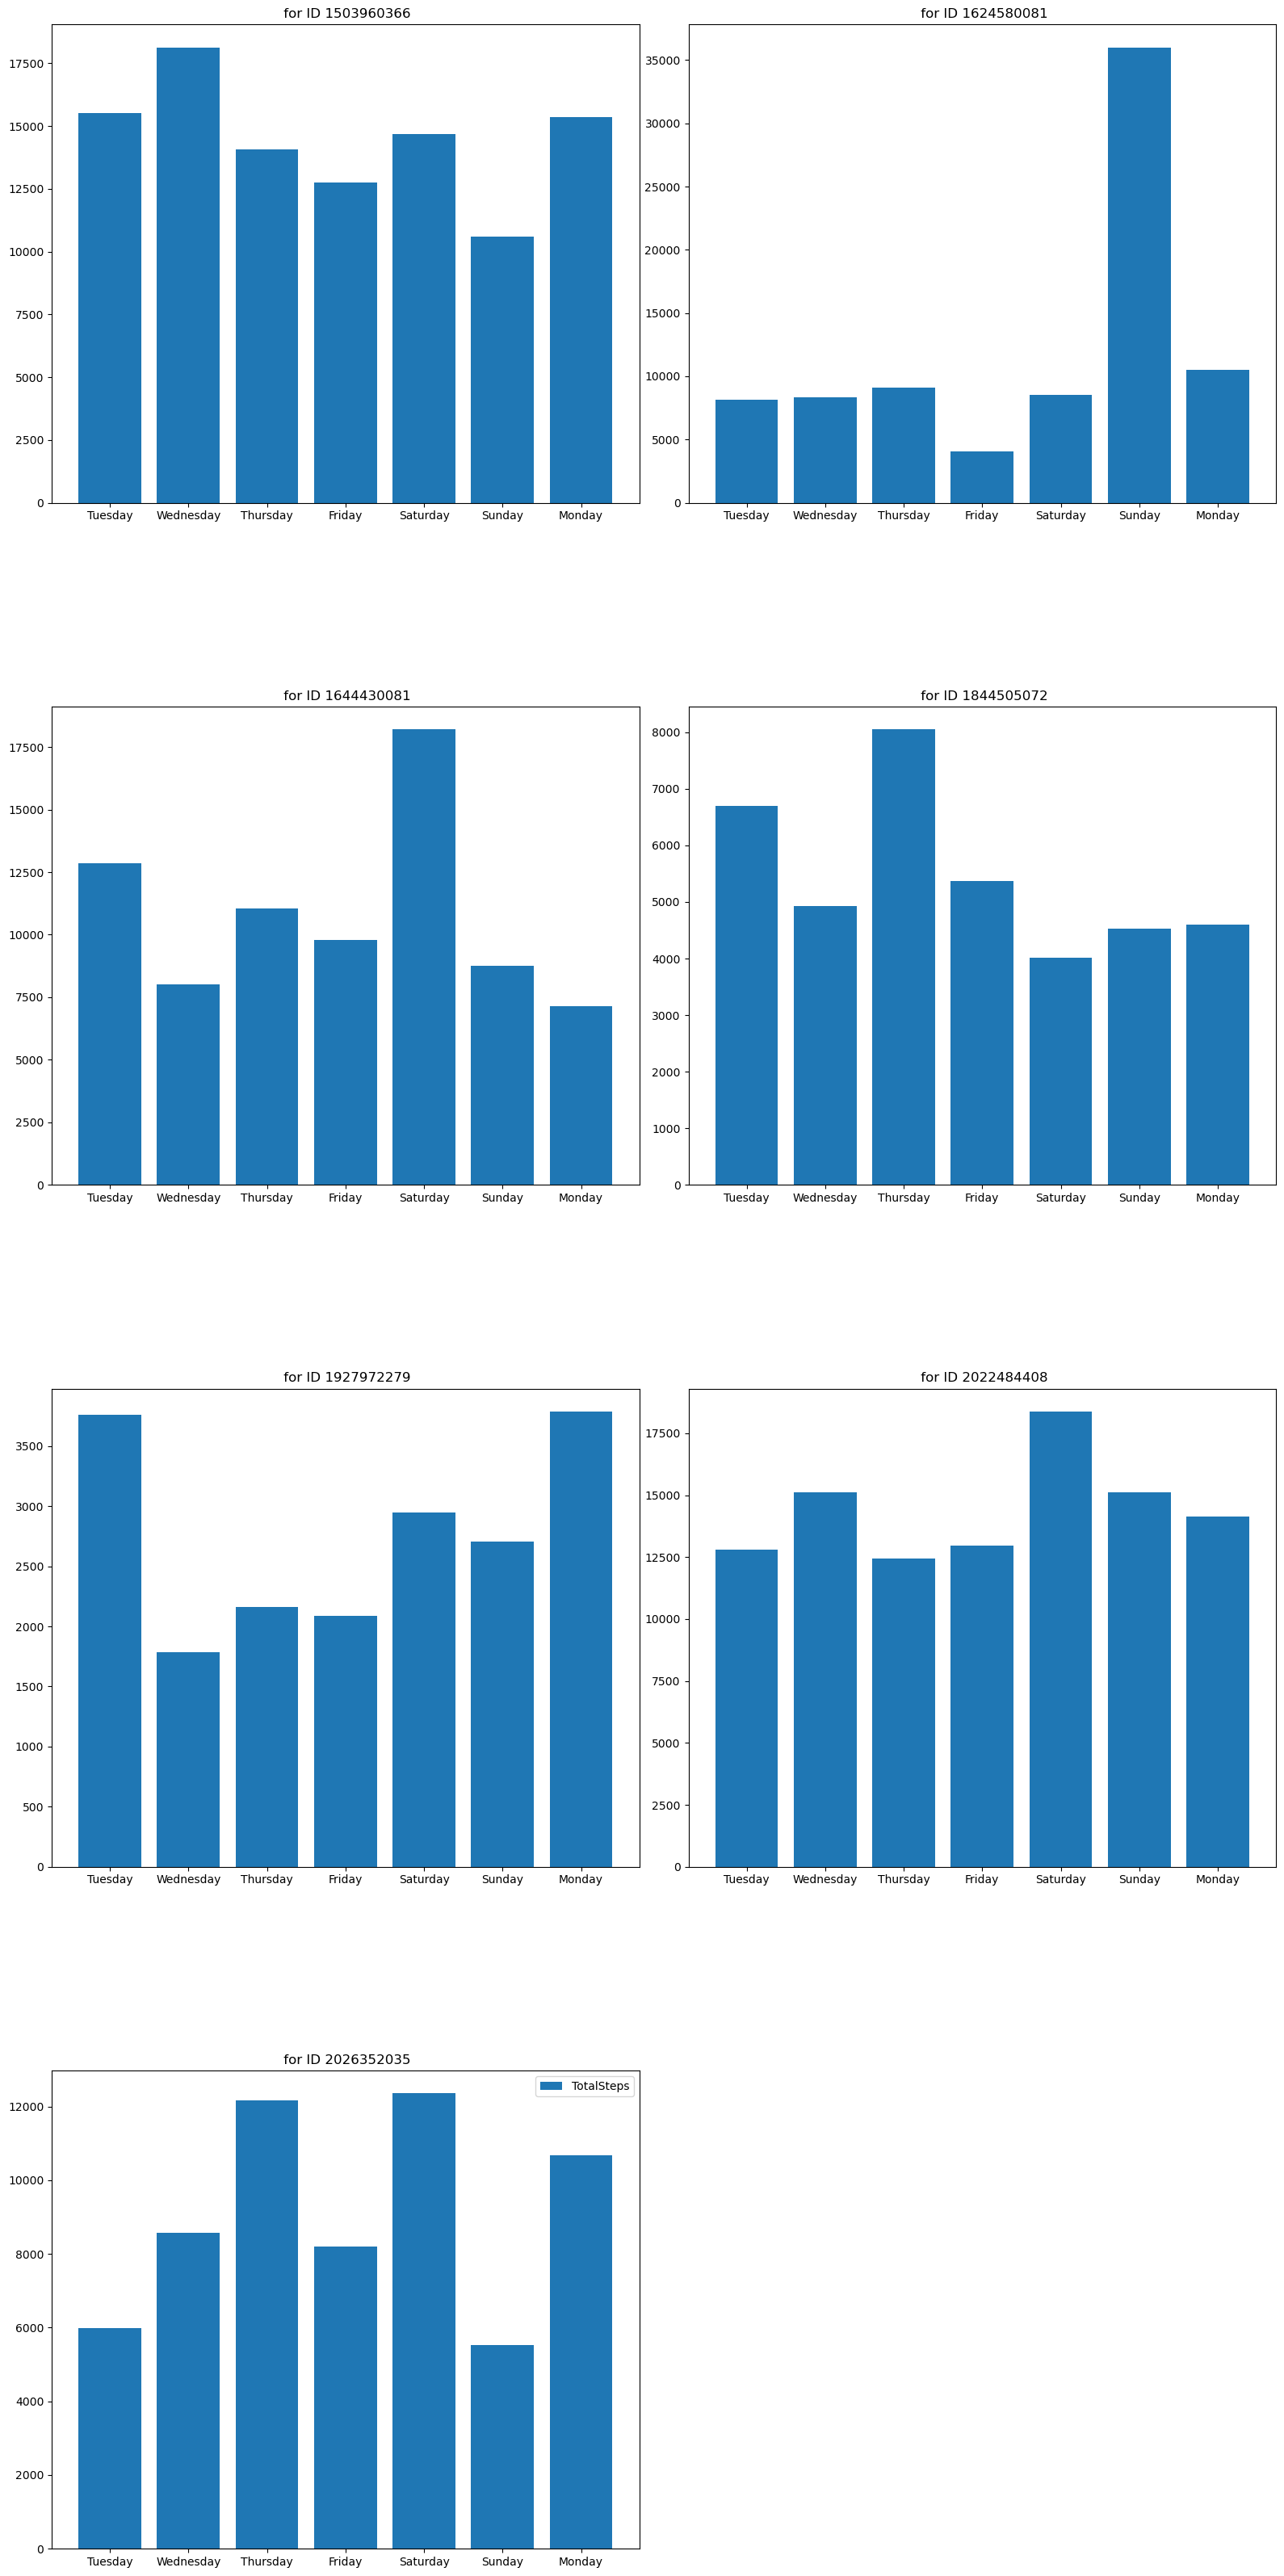

           id  mean_daily_steps  mean_daily_calories  mean_daily_sleep  \
0  1503960366      12116.741935          1816.419355        290.548387   
1  1624580081       5743.903226          1483.354839               NaN   
2  1644430081       7282.966667          2811.300000               NaN   
3  1844505072       2580.064516          1573.483871               NaN   
4  1927972279        916.129032          2172.806452               NaN   
5  2022484408      11370.645161          2509.967742               NaN   
6  2026352035       5566.870968          1540.645161        457.193548   

   mean_daily_active_minutes Activity_Category  Sedentary_Category  \
0                 277.806452       Very active  Moderate sedentary   
1                 167.967742    Lightly active      High sedentary   
2                 209.400000    Lightly active      High sedentary   
3                 116.870968         Sedentary      High sedentary   
4                  40.677419         Sedentary      High 

In [168]:
# Create aggregate DataFrame
# Loop through the groups
for name, group in grouped:
    print(f"Id: {name}")

    # Calculate the mean steps, sleep, and calories for this group by 'DayOfWeek'
    mean_values = group.groupby('ActivityDate').agg({
        'TotalSteps': 'mean',
        'TotalMinutesAsleep': 'mean',
        'Calories': 'mean',
        'TotalActiveMinutes': 'mean'
    }).reset_index()

    # Add 'Id' column to the mean_values DataFrame
    mean_values['Id'] = name

    # Append this to the aggregate DataFrame
    agg_df = pd.concat([agg_df, mean_values], ignore_index=True)

# Convert the DatetimeIndex to day names
Day = df['DayOfWeek']
agg_df = pd.concat([agg_df, Day], axis = 1)
# print(agg_df)

# Apply the function to the 'mean_daily_steps' column to create a new 'Activity_Category' column
agg_df['Activity_Category'] = agg_df['TotalSteps'].apply(classify_by_steps)
# Apply the function to the 'mean_daily_steps' column to create a new 'Sedentary_Category' column
agg_df['Sedentary_Category'] = agg_df['TotalMinutesAsleep'].apply(sedentary_segment)

# Testing statistical difference in caloric burn between the different user types based on the one-way ANOVA test.
# Create a list of the different user types and Group data by Activity_Category.
groups = [agg_df['Calories'][agg_df['Activity_Category'] == category] for category in ordered_categories]

# Perform ANOVA test on the groups 
f_statistic, p_value = stats.f_oneway(*groups) # *groups is used to unpack the list 
print("F statistic: ",f_statistic,"p-value: ", p_value) # p-value is less than 0.05, so we reject the null hypothesis.

analyzer = DataAnalyzer(agg_df)

# Define the configuration for plotting
config = {
    "bar_plot": {
        "x_column": "DayOfWeek",
        "y_column": ["TotalSteps", "Calories", "TotalMinutesAsleep"],
        "granularity": None, 
        "title_prefix": "Mean Daily Metrics by Day of the Week",
        "x_label": "Day of the Week",
        "y_label": "Mean Value",
        "rotate_x_ticks": True,
        "plot_type": "bar"
    }
}

# Call the trend_and_subplot_by_id method with the configuration
analyzer.trend_and_subplot_by_id(**config["bar_plot"])

# Data_analyzer for subplotting by ID
data_analyzer.trend_and_subplot_by_id(x_column='DayOfWeek', y_column='TotalSteps', plot_type='bar')

# Average Data by Day by Id
daily_avg_ID['efficiency_per_step'] = daily_avg_ID['mean_daily_calories'] / daily_avg_ID['mean_daily_steps']
daily_avg_ID['efficiency_per_minute'] = daily_avg_ID['mean_daily_calories'] / daily_avg_ID['mean_daily_active_minutes']

# Average Data by Day by Id by day of week
agg_df['efficiency_per_step'] = agg_df['Calories'] / agg_df['TotalSteps']
agg_df['efficiency_per_minute'] = agg_df['Calories'] / agg_df['TotalActiveMinutes']

print(daily_avg_ID)
print(agg_df)

# # Plot Efficiency per Step by Day of Week. See if users there are days when users are more efficient in their activities.
# # Define the configuration for plotting
# config = {
#     "bar_plot": {
#         "x_column": "efficiency_per_step",
#         "y_column": "DayOfWeek",
#         "granularity": None, 
#         "title_prefix": "Efficiency per Step by Day of Week",
#         "x_label": "Day of the Week",
#         "y_label": "Mean Value",
#         "rotate_x_ticks": True,
#         "plot_type": "bar"
#     }
# }

# analyzer.trend_and_subplot_by_id(**config["bar_plot"])


# # # Plot Efficiency per Active Minute
# config = {
#     "scatter_plot": {
#         "x_column": "efficiency_per_minute",
#         "y_column": "TotalActiveMinutes",
#         "granularity": None, 
#         "title_prefix": "Efficiency per Active Minute",
#         "x_label": "Efficiency_per_minute",
#         "y_label": "TotalActiveMinutes",
#         "rotate_x_ticks": True,
#         "plot_type": "scatter"
#     }
# }

# analyzer.trend_and_subplot_by_id(**config["scatter_plot"])

# The average calories burned for each category of activity
print(daily_avg_ID.groupby('Activity_Category')['mean_daily_calories'].mean())

# # statistical summary of mean daily calories
# daily_avg_ID.groupby('Activity_Category')['mean_daily_calories'].describe()

# # 1. Set the caloric goal
# caloric_goal = 2000

# # 2. Determine days meeting the goal
# daily_avg_ID['meets_goal'] = daily_avg_ID['mean_daily_calories'] >= caloric_goal

# # 3. Calculate the percentage
# percentage_meeting_goal = (daily_avg_ID['meets_goal'].sum() / len(daily_avg_ID)) * 100

# print(f"The percentage of days users meet or exceed the caloric goal is: {percentage_meeting_goal:.2f}%")

R^2: 0.5279910285815679
Root Mean Squared Error: 337.3333658173044
Mean Absolute Error: 123.05142745473889
              Feature  Coefficient
0          TotalSteps     0.000010
1  TotalMinutesAsleep    -0.000199
2  TotalActiveMinutes     0.005152
3          TotalSteps     0.044158
4  TotalMinutesAsleep    -0.036817
5  TotalActiveMinutes     0.405474


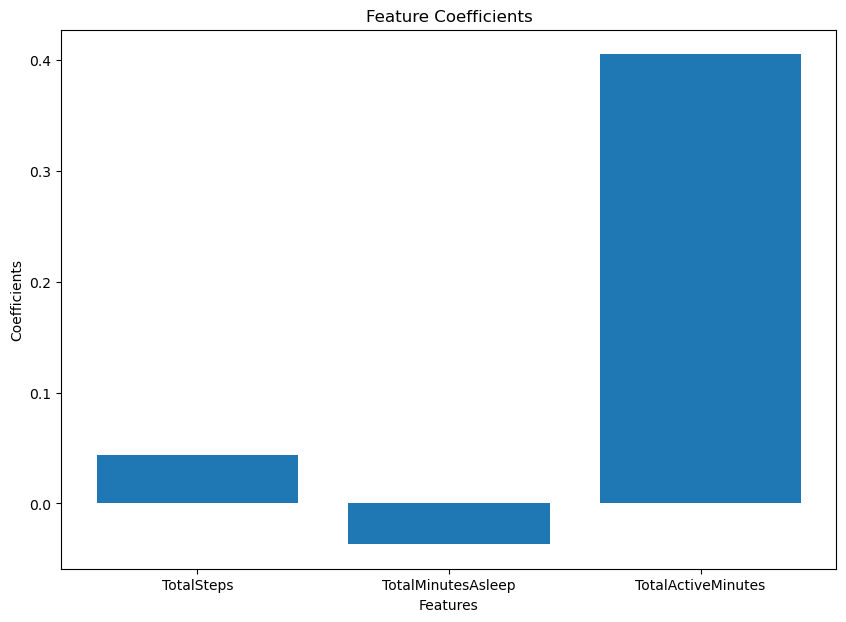

Best Hyperparameters: {'regressor__fit_intercept': False, 'regressor__normalize': True}
R-squared with Best Estimator: 0.527991028581762
Mean Absolute Error with Best Estimator: 123.05142745483069
Root Mean Squared Error with Best Estimator: 337.33336581723506


In [169]:
## Regression Analysis
# Import necessary modules
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer  # Import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV

# List of IDs to be removed
ids_to_remove = [1624580081, 1644430081, 1844505072, 1927972279, 2022484408]

# Create a new DataFrame without the specified IDs
filtered_agg_df = agg_df[~agg_df['Id'].isin(ids_to_remove)]

# Define the features and target
X = filtered_agg_df[['TotalSteps', 'TotalMinutesAsleep', 'TotalActiveMinutes']]
y = filtered_agg_df['Calories']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

# Create a pipeline with preprocessing and modeling steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['TotalSteps', 'TotalMinutesAsleep', 'TotalActiveMinutes']),
        ('imputer', SimpleImputer(strategy='mean'), ['TotalSteps', 'TotalMinutesAsleep', 'TotalActiveMinutes'])
    ])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Predict on the test data
y_pred = pipeline.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(r2_score(y_test, y_pred)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Absolute Error: {mae}")

# Get feature names from the ColumnTransformer
feature_names = (
    list(pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out(['TotalSteps', 'TotalMinutesAsleep', 'TotalActiveMinutes'])) +
    ['TotalSteps', 'TotalMinutesAsleep', 'TotalActiveMinutes']
)

# Get coefficients from the LinearRegression model
coefficients = pipeline.named_steps['regressor'].coef_

# Create a DataFrame of the features and coefficients
feature_coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})

# Print the feature coefficients
print(feature_coef_df)

# Plot the coefficients
plt.figure(figsize=(10, 7))
plt.bar(df_coef['features'], df_coef['coefficients'])
plt.xlabel('Features')
plt.ylabel('Coefficients')
plt.title('Feature Coefficients')
plt.show()

# Define a parameter grid for hyperparameter tuning
param_grid = {
    'regressor__fit_intercept': [True, False],
    'regressor__normalize': [True, False],
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')

# Fit the GridSearchCV on the training data
grid_search.fit(X_train, y_train)

# Get the best estimator and its hyperparameters
best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_

print("Best Hyperparameters:", best_params)

# Predict on the test data using the best estimator
y_pred = best_estimator.predict(X_test)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)
print("R-squared with Best Estimator:", r_squared)

# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error with Best Estimator:", mae)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error with Best Estimator:", rmse)


In [170]:
# Print the coefficients and their corresponding feature names
for coef, feature in zip(coefficients, X.columns):
    print(f"{feature}: {coef}")

TotalSteps: 1.012015003421571e-05
TotalMinutesAsleep: -0.00019896232710913688
TotalActiveMinutes: 0.005152336155855576


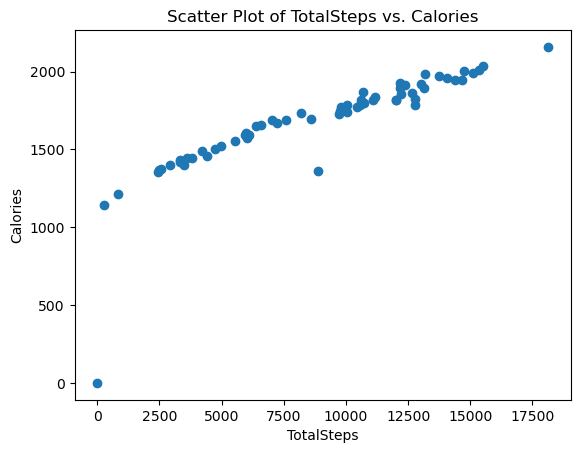

In [171]:
import matplotlib.pyplot as plt

# Scatter plot of a single feature vs. target
plt.scatter(X['TotalSteps'], y)
plt.xlabel('TotalSteps')
plt.ylabel('Calories')
plt.title('Scatter Plot of TotalSteps vs. Calories')
plt.show()

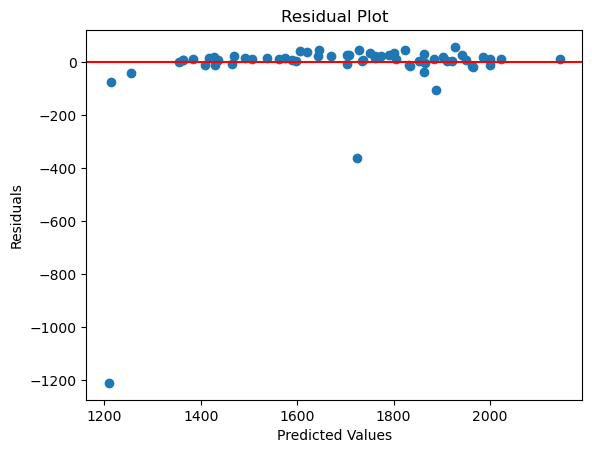

In [172]:
# Calculate residuals
y_pred = reg_all.predict(X)
residuals = y - y_pred

# Plot residuals
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()

In [173]:
import statsmodels.api as sm

# Fit the model using statsmodels for p-values
X = sm.add_constant(X)  # Add a constant for the intercept term
model = sm.OLS(y, X).fit()

# Access p-values
p_values = model.pvalues

# Print feature names and their p-values
for feature, p_value in zip(X.columns, p_values):
    print(f"{feature}: {p_value}")

const: 2.901084097127843e-18
TotalSteps: 3.2200105970675144e-10
TotalMinutesAsleep: 0.053293679390869673
TotalActiveMinutes: 0.00669443227570818
